In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default') 

In [2]:
data_df = pd.read_excel('Rawdata_baania.xlsx')
data_eating_score_df = pd.read_excel('Rawdata_eating_score.xlsx')
data_living_score_df = pd.read_excel('Rawdata_living_score.xlsx')

###### Data exploration ######

In [3]:
#1. ตรวจสอบแถวที่ null เมื่อ filter ตามข้อมูลที่ต้องการ
propertytype_list = ['Detached House', 'Townhome', 'Twin house', 'Condo']
df_baania_data_checking_null = data_df[['row_number','name_en','propertytype_name_en','price_min','subdistrict_name_th','district_name_th','province_name_th', 'date_updated']][(data_df['province_name_th'] != 'กรุงเทพมหานคร') & (data_df['propertytype_name_en'].isin(propertytype_list))]
df_baania_data_checking_null.isnull().sum(axis = 0)

row_number               0
name_en                  0
propertytype_name_en     0
price_min               86
subdistrict_name_th     15
district_name_th         5
province_name_th         5
date_updated             5
dtype: int64

,price_min,Freq
0,0,716
1,100000,4
2,101000,1
3,108000,1
4,120000,1
...,...,...
1339,123000000,1
1340,124000000,1
1341,140000000,2
1342,280000000,1


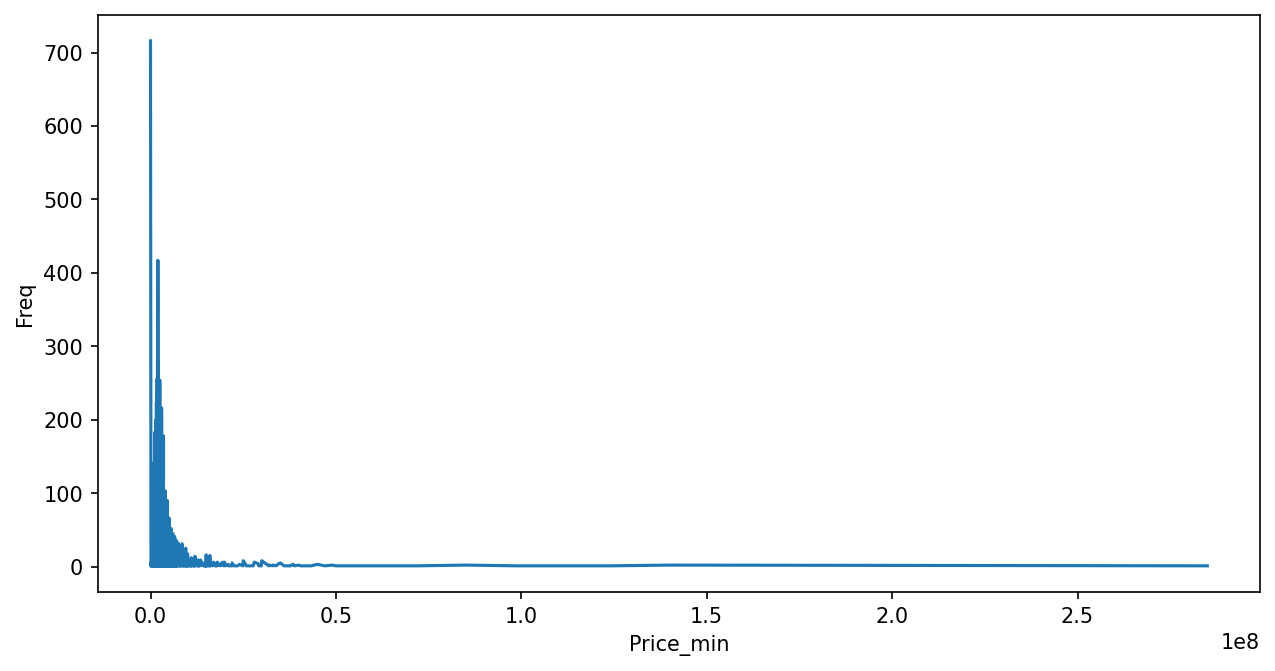

In [23]:
#2. ถึงแม้ว่า Column ราคาจะไม่เป็นค่า Null แต่มีค่า = 0 โดยจะทำการตัดออก
df_price_min_checking = df_baania_data_checking_null[['row_number','name_en','propertytype_name_en','price_min','subdistrict_name_th','district_name_th','province_name_th', 'date_updated']][(df_baania_data_checking_null['price_min'].notnull())]
df = df_price_min_checking.groupby(['price_min']).size().reset_index(name='Freq')
display(df)

plt.figure(figsize=(10,5), dpi=150)
plt.plot(df['price_min'], df['Freq'], label = "Test")
plt.xlabel('Price_min', fontsize=10)
plt.ylabel('Freq', fontsize=10)
plt.ticklabel_format(axis='x',useOffset=False)

In [5]:
#3. สำหรับข้อมูล Eating score และ Living score จะให้คะแนนมาในระดับ subdistrict
# ปัญหาที่พบ คือ ยกตัวอย่าง "บ้านฉาง" เป็นชื่อของ subdistrict ของหลาย district ทำให้การ mapping score อาจจะผิดได้ จึงได้ทำการสร้าง Key ขึ้นมาสำหรับ mapping
data_eating_score_df[['row_number', 'subdistrict_name_th','district_name_th','province_name_th']][data_eating_score_df['subdistrict_name_th'] == 'บ้านฉาง']

,row_number,subdistrict_name_th,district_name_th,province_name_th
202,183,บ้านฉาง,เมืองปทุมธานี,ปทุมธานี
301,170,บ้านฉาง,บ้านฉาง,ระยอง


###### Data cleansing & preparation ######

In [6]:
# cleansing และสร้าง Key สำหรับ mapping score ของ data ตัวหลัก "Residental Project Data" 
propertytype_list = ['Detached House', 'Townhome', 'Twin house', 'Condo']
df_baania_data = data_df[['row_number','name_en','propertytype_name_en','price_min','subdistrict_name_th','district_name_th','province_name_th', 'date_updated']][data_df['row_number'].notnull()]
df_baania_data = df_baania_data[['row_number','name_en','propertytype_name_en','price_min','subdistrict_name_th','district_name_th','province_name_th', 'date_updated']][(df_baania_data['province_name_th'] != 'กรุงเทพมหานคร') & (df_baania_data['propertytype_name_en'].isin(propertytype_list)) & (df_baania_data['price_min'] > 0) & (df_baania_data['price_min'].notnull())]
df_baania_data['subdistrict_mapping_key'] = (df_baania_data['subdistrict_name_th'] + df_baania_data['district_name_th'] + df_baania_data['province_name_th'])
df_baania_data['district_mapping_key'] = (df_baania_data['district_name_th'] + df_baania_data['province_name_th'])
#df_baania_data.head()

In [7]:
# สร้าง Key mapping ที่ Eating Score By Location
data_eating_score_df['eating_mapping_key'] = (data_eating_score_df['subdistrict_name_th'] + data_eating_score_df['district_name_th'] + data_eating_score_df['province_name_th'])
data_eating_score_df['eating_district_mapping_key'] = (data_eating_score_df['district_name_th'] + data_eating_score_df['province_name_th'])
data_eating_score_df['Average_eating_score'] = (data_eating_score_df['eating_daytime'] +  data_eating_score_df['eating_nighttime'])/2
#data_eating_score_df.head()

In [8]:
# คำนวณค่าเฉลี่ย eating score
data_eating_score_subdistrict = data_eating_score_df.groupby('eating_mapping_key')[['Average_eating_score']].apply(lambda x: x.mean())
data_eating_score_district = data_eating_score_df.groupby('eating_district_mapping_key')[['Average_eating_score']].apply(lambda x: x.mean())

In [9]:
# สร้าง Key mapping ที่ Living Score By Location
data_living_score_df['living_mapping_key'] = (data_living_score_df['subdistrict_name_th'] + data_living_score_df['district_name_th'] + data_living_score_df['province_name_th'])
data_living_score_df['living_district_mapping_key'] = (data_living_score_df['district_name_th'] + data_living_score_df['province_name_th'])
data_living_score_df['Average_living_score'] = (data_living_score_df['walk_total'] + data_living_score_df['access_total'] + data_living_score_df['drive_total'])/3
#data_living_score_df.head()

In [10]:
# คำนวณค่าเฉลี่ย Living score
data_living_score_subdistrict = data_living_score_df.groupby('living_mapping_key')[['Average_living_score']].apply(lambda x: x.mean()).reset_index()
data_living_score_district = data_living_score_df.groupby('living_district_mapping_key')[['Average_living_score']].apply(lambda x: x.mean()).reset_index()

In [11]:
# รวมข้อมูลค่าเฉลี่ย Living score และ eating score ของ subdistrict และ district
data_score_inner_subdistrict = pd.merge( data_living_score_subdistrict, data_eating_score_subdistrict, left_on='living_mapping_key', right_on='eating_mapping_key' )
data_score_inner_subdistrict_mapping = data_score_inner_subdistrict[['living_mapping_key','Average_living_score', 'Average_eating_score']]
data_score_inner_district = pd.merge( data_living_score_district, data_eating_score_district, left_on='living_district_mapping_key', right_on='eating_district_mapping_key' )
data_score_inner_district_mapping = data_score_inner_district[['living_district_mapping_key','Average_living_score', 'Average_eating_score']]

In [12]:
# Rawdata_Df คือ data ชุดสุดท้าย ที่เกิดจากการรวมของ ข้อมูล Residental Project Data กับ ข้อมูล score
Rawdata_df = pd.merge( df_baania_data, data_score_inner_subdistrict_mapping, left_on='subdistrict_mapping_key', right_on='living_mapping_key', how='left' )

In [13]:
# ส่วนที่ mapping score ด้วย subdistrict ไม่เจอ จะแทนที่ด้วยค่าเฉลี่ยของ district แทน
Rawdata_df_lot1 = Rawdata_df[['row_number','name_en','propertytype_name_en','price_min','subdistrict_name_th','district_name_th','province_name_th', 'subdistrict_mapping_key', 'district_mapping_key','date_updated', 'Average_living_score', 'Average_eating_score']][Rawdata_df['Average_living_score'].notnull()]
Rawdata_df_lot2 = Rawdata_df[['row_number','name_en','propertytype_name_en','price_min','subdistrict_name_th','district_name_th','province_name_th', 'subdistrict_mapping_key', 'district_mapping_key','date_updated']][Rawdata_df['Average_living_score'].isnull()]

In [14]:
Rawdata_df_lot2_merge = pd.merge( Rawdata_df_lot2, data_score_inner_district_mapping, left_on='district_mapping_key', right_on='living_district_mapping_key' )
Rawdata_df_lot2_to_concat = Rawdata_df_lot2_merge[['row_number','name_en','propertytype_name_en','price_min','subdistrict_name_th','district_name_th','province_name_th', 'subdistrict_mapping_key', 'district_mapping_key','date_updated', 'Average_living_score', 'Average_eating_score']]
#Rawdata_df_lot2_to_concat

In [15]:
# รวมข้อมูลจากการ mapping score เข้าด้วยกัน และหาค่าเฉลี่ยระหว่าง Living score และ Eating score
Rawdata_concat = pd.concat( [Rawdata_df_lot1, Rawdata_df_lot2_to_concat], ignore_index=True )

In [16]:
# สุดท้ายเหลือข้อมูลที่ Mapping กันได้เพียง 8 จังหวัด
Rawdata_concat['Average_total_Score'] = (Rawdata_concat['Average_living_score'] + Rawdata_concat['Average_eating_score'])/2
Rawdata_concat['Update_year'] = Rawdata_concat['date_updated'].dt.year
Rawdata_concat['price_per_score'] = (Rawdata_concat['price_min']/Rawdata_concat['Average_total_Score'])
#Rawdata_concat
Rawdata_concat.groupby(['province_name_th'])[['row_number']].nunique().sort_values( ['row_number'], ascending=[False] ).reset_index()

,province_name_th,row_number
0,ชลบุรี,2467
1,นนทบุรี,1967
2,เชียงใหม่,1332
3,ปทุมธานี,1253
4,สมุทรปราการ,1243
5,ระยอง,956
6,ภูเก็ต,727
7,นครปฐม,335


###### Graph preparation ######

In [17]:
datatogroupby = Rawdata_concat.loc[Rawdata_concat['province_name_th'] == 'สมุทรปราการ']
grouped_multiple_Samutprakarn = datatogroupby.groupby(['propertytype_name_en']).agg({'price_per_score': ['mean']})
datatogroupby = Rawdata_concat.loc[Rawdata_concat['province_name_th'] == 'นนทบุรี']
grouped_multiple_Nontaburi = datatogroupby.groupby(['propertytype_name_en']).agg({'price_per_score': ['mean']})
datatogroupby = Rawdata_concat.loc[Rawdata_concat['province_name_th'] == 'ชลบุรี']
grouped_multiple_Chonburi = datatogroupby.groupby(['propertytype_name_en']).agg({'price_per_score': ['mean']})
datatogroupby = Rawdata_concat.loc[Rawdata_concat['province_name_th'] == 'เชียงใหม่']
grouped_multiple_Chiangmai = datatogroupby.groupby(['propertytype_name_en']).agg({'price_per_score': ['mean']})
datatogroupby = Rawdata_concat.loc[Rawdata_concat['province_name_th'] == 'ระยอง']
grouped_multiple_Rayong = datatogroupby.groupby(['propertytype_name_en']).agg({'price_per_score': ['mean']})
datatogroupby = Rawdata_concat.loc[Rawdata_concat['province_name_th'] == 'ภูเก็ต']
grouped_multiple_Phuket = datatogroupby.groupby(['propertytype_name_en']).agg({'price_per_score': ['mean']})
datatogroupby = Rawdata_concat.loc[Rawdata_concat['province_name_th'] == 'นครปฐม']
grouped_multiple_Nakornpatom = datatogroupby.groupby(['propertytype_name_en']).agg({'price_per_score': ['mean']})
datatogroupby = Rawdata_concat.loc[Rawdata_concat['province_name_th'] == 'ปทุมธานี']
grouped_multiple_Pathumthani = datatogroupby.groupby(['propertytype_name_en']).agg({'price_per_score': ['mean']})

Text(0, 10, '70,051')

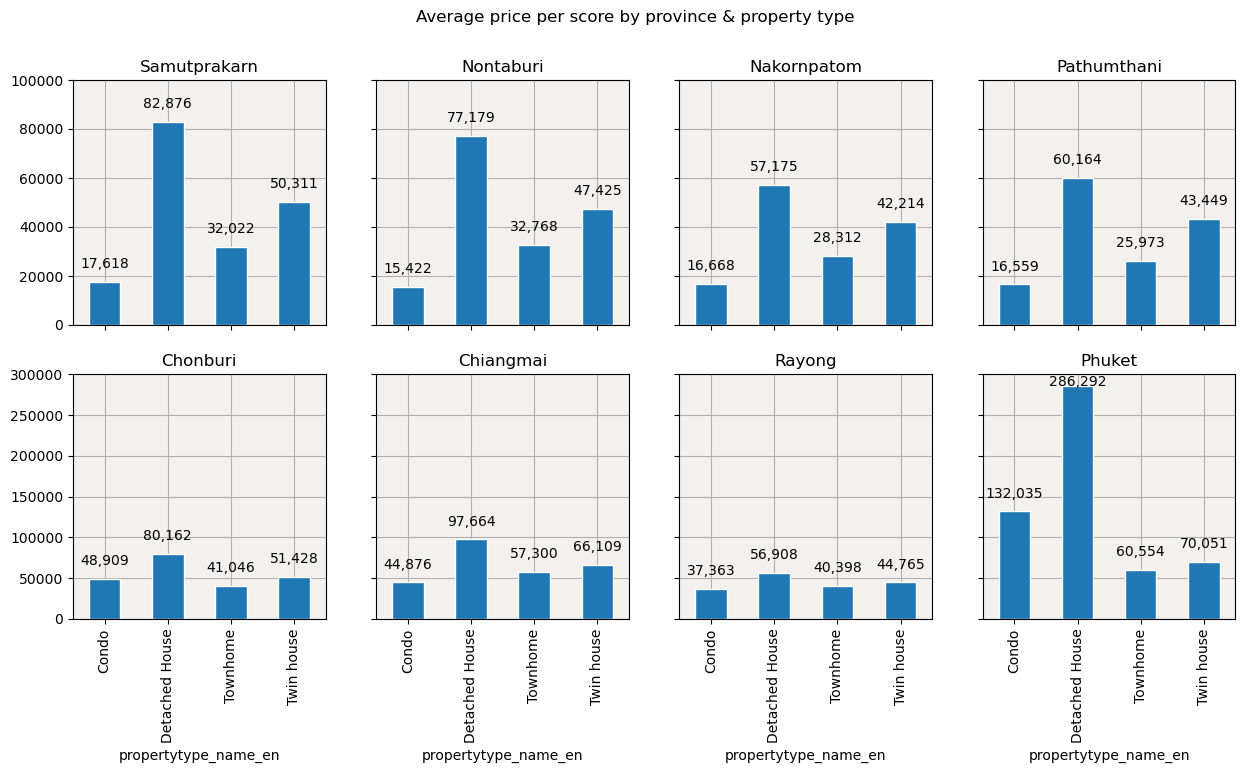

In [18]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(15, 7))
fig.suptitle('Average price per score by province & property type')

ax[0,0].set_title(f"Samutprakarn")
grouped_multiple_Samutprakarn.plot.bar(ax=ax[0,0],grid=True, edgecolor="white",zorder=2)
ax[0,0].set_axisbelow(True)
ax[0,0].set_facecolor('#F2F1F0')
ax[0,0].set_ylim([0, 100000])
ax[0,0].get_legend().remove()

ax[0,0].annotate("17,618", 
             xy=(0, 17618 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,0].annotate("82,876", 
             xy=(1, 82876 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,0].annotate("32,022", 
             xy=(2, 32022 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,0].annotate("50,311", 
             xy=(3, 50311 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,1].set_title(f"Nontaburi")
grouped_multiple_Nontaburi.plot.bar(ax=ax[0,1],grid=True, edgecolor="white",zorder=2)
ax[0,1].set_axisbelow(True)
ax[0,1].set_facecolor('#F2F1F0')
ax[0,1].set_ylim([0, 100000])
ax[0,1].get_legend().remove()

ax[0,1].annotate("15,422", 
             xy=(0, 15422 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,1].annotate("77,179", 
             xy=(1, 77179 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,1].annotate("32,768", 
             xy=(2, 32768 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,1].annotate("47,425", 
             xy=(3, 47425 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,2].set_title(f"Nakornpatom")
grouped_multiple_Nakornpatom.plot.bar(ax=ax[0,2],grid=True, edgecolor="white",zorder=2)
ax[0,2].set_axisbelow(True)
ax[0,2].set_facecolor('#F2F1F0')
ax[0,2].set_ylim([0, 100000])
ax[0,2].get_legend().remove()

ax[0,2].annotate("16,668", 
             xy=(0, 16668 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,2].annotate("57,175", 
             xy=(1, 57175 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,2].annotate("28,312", 
             xy=(2, 28312 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,2].annotate("42,214", 
             xy=(3, 42214 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,3].set_title(f"Pathumthani")
grouped_multiple_Pathumthani.plot.bar(ax=ax[0,3],grid=True, edgecolor="white",zorder=2)
ax[0,3].set_axisbelow(True)
ax[0,3].set_facecolor('#F2F1F0')
ax[0,3].set_ylim([0, 100000])
ax[0,3].get_legend().remove()

ax[0,3].annotate("16,559", 
             xy=(0, 16559 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,3].annotate("60,164", 
             xy=(1, 60164 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,3].annotate("25,973", 
             xy=(2, 25973 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[0,3].annotate("43,449", 
             xy=(3, 43449 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,0].set_title(f"Chonburi")
grouped_multiple_Chonburi.plot.bar(ax=ax[1,0],grid=True, edgecolor="white",zorder=2)
ax[1,0].set_axisbelow(True)
ax[1,0].set_facecolor('#F2F1F0')
ax[1,0].get_legend().remove()

ax[1,0].annotate("48,909", 
             xy=(0, 48909 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,0].annotate("80,162", 
             xy=(1, 80162 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,0].annotate("41,046", 
             xy=(2, 41046 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,0].annotate("51,428", 
             xy=(3, 51428 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,1].set_title(f"Chiangmai")
grouped_multiple_Chiangmai.plot.bar(ax=ax[1,1],grid=True, edgecolor="white",zorder=2)
ax[1,1].set_axisbelow(True)
ax[1,1].set_facecolor('#F2F1F0')
ax[1,1].get_legend().remove()

ax[1,1].annotate("44,876", 
             xy=(0, 44876 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,1].annotate("97,664", 
             xy=(1, 97664 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,1].annotate("57,300", 
             xy=(2, 57300 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,1].annotate("66,109", 
             xy=(3, 66109 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,2].set_title(f"Rayong")
grouped_multiple_Rayong.plot.bar(ax=ax[1,2],grid=True, edgecolor="white",zorder=2)
ax[1,2].set_axisbelow(True)
ax[1,2].set_facecolor('#F2F1F0')
ax[1,2].get_legend().remove()

ax[1,2].annotate("37,363", 
             xy=(0, 37363 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,2].annotate("56,908", 
             xy=(1, 56908 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,2].annotate("40,398", 
             xy=(2, 40398 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,2].annotate("44,765", 
             xy=(3, 44765 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,3].set_title(f"Phuket")
grouped_multiple_Phuket.plot.bar(ax=ax[1,3],grid=True, edgecolor="white",zorder=2)
ax[1,3].set_axisbelow(True)
ax[1,3].set_facecolor('#F2F1F0')
ax[1,3].get_legend().remove()

ax[1,3].annotate("132,035", 
             xy=(0, 132035 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,3].annotate("286,292", 
             xy=(1, 286292 ), xycoords='data', 
             xytext=(0,0), textcoords='offset points',
             ha='center')

ax[1,3].annotate("60,554", 
             xy=(2, 60554 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

ax[1,3].annotate("70,051", 
             xy=(3, 70051 ), xycoords='data', 
             xytext=(0,10), textcoords='offset points',
             ha='center')

In [19]:
datagroupbyyear = Rawdata_concat.loc[Rawdata_concat['propertytype_name_en'] == 'Condo']
Property_by_year_Condo = datagroupbyyear.groupby(['Update_year']).agg({'price_min': ['mean']}).reset_index()
datagroupbyyear = Rawdata_concat.loc[Rawdata_concat['propertytype_name_en'] == 'Detached House']
Property_by_year_DetachedHouse = datagroupbyyear.groupby(['Update_year']).agg({'price_min': ['mean']}).reset_index()
datagroupbyyear = Rawdata_concat.loc[Rawdata_concat['propertytype_name_en'] == 'Twin house']
Property_by_year_Twinhouse = datagroupbyyear.groupby(['Update_year']).agg({'price_min': ['mean']}).reset_index()
datagroupbyyear = Rawdata_concat.loc[Rawdata_concat['propertytype_name_en'] == 'Townhome']
Property_by_year_Townhome = datagroupbyyear.groupby(['Update_year']).agg({'price_min': ['mean']}).reset_index()

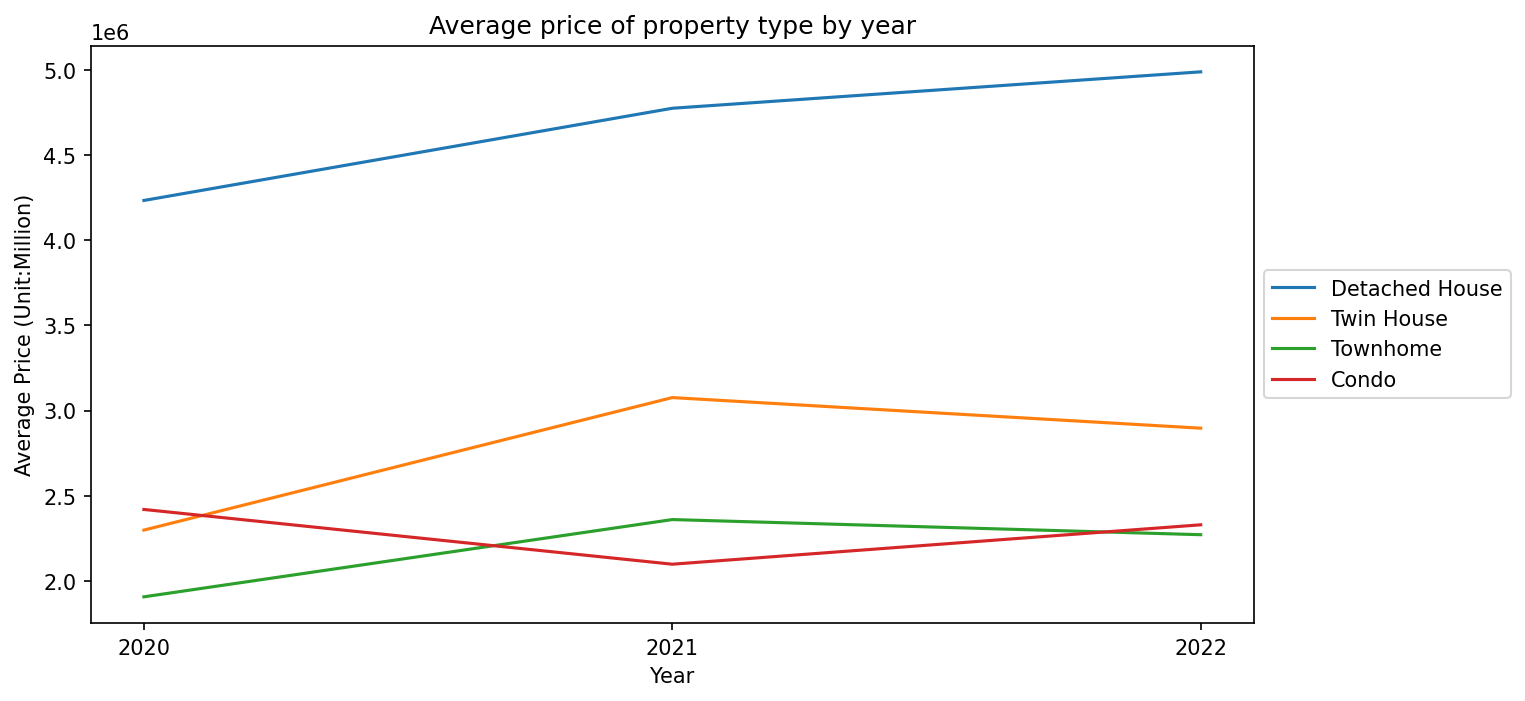

In [20]:
plt.figure(figsize=(10,5), dpi=150)
plt.title('Average price of property type by year')
plt.plot(Property_by_year_DetachedHouse['Update_year'], Property_by_year_DetachedHouse['price_min']['mean'], label = "Detached House")
plt.plot(Property_by_year_Twinhouse['Update_year'], Property_by_year_Twinhouse['price_min']['mean'], label = "Twin House")
plt.plot(Property_by_year_Townhome['Update_year'], Property_by_year_Townhome['price_min']['mean'], label = "Townhome")
plt.plot(Property_by_year_Condo['Update_year'], Property_by_year_Condo['price_min']['mean'], label = "Condo")
plt.legend(bbox_to_anchor =(1, 0.5) ,loc='center left')
plt.xticks(range(2020,2023,1))
plt.xlabel('Year', fontsize=10)
plt.ylabel('Average Price (Unit:Million)', fontsize=10)
plt.show()